In [62]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import StandardScaler
import numpy as np

In [113]:
df = pd.read_csv('soccer_statistics.csv')
df.head()

,squad,possession,games,goals,goals_against_gk,shots_total,shots_on_target_pct,passes_pct_short,passes_pct_medium,passes_pct_long,...,dribble_tackles_pct,pressure_regain_pct,blocks,interceptions,touches,dribbles_completed_pct,carries,passes_received_pct,year,league
0,Arsenal,61.5,38,73,51,590,38.5,89.2,88.9,66.6,...,39.3,32.2,509,484,29511,61.0,19525,87.8,2021,Premier League
1,Bournemouth,47.8,38,45,61,473,32.3,86.3,83.2,54.2,...,34.7,27.5,622,466,22844,55.7,13059,83.0,2021,Premier League
2,Brighton,43.7,38,33,54,381,29.7,84.4,81.8,55.7,...,31.6,28.2,639,556,20800,62.1,11626,79.9,2021,Premier League
3,Burnley,43.9,38,35,39,388,32.5,83.5,79.2,47.9,...,34.8,27.5,675,529,19878,58.3,10366,77.3,2021,Premier League
4,Chelsea,55.4,38,60,38,602,34.7,88.8,88.7,65.9,...,40.8,32.8,510,514,27447,60.4,18152,86.6,2021,Premier League


In [114]:
#Select feature
X = df[['possession','shots_on_target_pct', 'passes_pct_short', 'passes_pct_medium','passes_pct_long','dribble_tackles_pct',
       'pressure_regain_pct','dribbles_completed_pct','passes_received_pct']]

#Some of the features (shots, tackles, block, interceptions, touches, carries) are divided by total matches per season
X[['shots_pg','tackles_pg','tackles_won_pg','block_pg','interceptions_pg','touches_pg','carries_pg']] = \
df[['shots_total','tackles','tackles_won','blocks','interceptions','touches','carries']].div(df.games, axis=0)

#select goals won per match in one season
y = df.goals/df.games

X.head()

/home/zimu/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,possession,shots_on_target_pct,passes_pct_short,passes_pct_medium,passes_pct_long,dribble_tackles_pct,pressure_regain_pct,dribbles_completed_pct,passes_received_pct,shots_pg,tackles_pg,tackles_won_pg,block_pg,interceptions_pg,touches_pg,carries_pg
0,61.5,38.5,89.2,88.9,66.6,39.3,32.2,61.0,87.8,15.526316,18.157895,11.473684,13.394737,12.736842,776.605263,513.815789
1,47.8,32.3,86.3,83.2,54.2,34.7,27.5,55.7,83.0,12.447368,15.315789,8.710526,16.368421,12.263158,601.157895,343.657895
2,43.7,29.7,84.4,81.8,55.7,31.6,28.2,62.1,79.9,10.026316,18.210526,11.763158,16.815789,14.631579,547.368421,305.947368
3,43.9,32.5,83.5,79.2,47.9,34.8,27.5,58.3,77.3,10.210526,15.210526,9.236842,17.763158,13.921053,523.105263,272.789474
4,55.4,34.7,88.8,88.7,65.9,40.8,32.8,60.4,86.6,15.842105,18.947368,11.710526,13.421053,13.526316,722.289474,477.684211


In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
#Standardize the test
std = StandardScaler()
std.fit(X_train.values)
## apply the scaler to the train set
X_tr = pd.DataFrame(std.transform(X_train.values), columns = X_train.columns)
X_tr.index = X_train.index

## Apply the scaler to the test set
X_te = pd.DataFrame(std.transform(X_test.values), columns = X_test.columns)
X_te.index = X_test.index

def varianceinflationfactor_comp(X):
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['vif'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif)
    print('--------------------')

def dropvar(X):
    # average passes percentage at different distances
    X['avg_passes_pct'] = (X.passes_pct_short + X.passes_pct_medium + X.passes_pct_long)/3
    #passes_received_pct, avg_passes_pct are linearly correlated
    #touches and carries are linearly correlated with passes
    #tackles_pg and tackles_won_pg are linearly correlated
    X = X.drop(columns = [ 'possession','passes_pct_short','passes_pct_medium','passes_pct_long',\
                            'passes_received_pct','tackles_won_pg','touches_pg','carries_pg'])
    return X

#compute variance inflation factor to inspect multicolinearity
varianceinflationfactor_comp(X_tr)

# drop and transform features with multicolinearity
X_tr_vif = dropvar(X_tr)
X_te_vif = dropvar(X_te)

# X_tr_vif['block_pg_2'] = np.exp(-(X_tr_vif.block_pg))
# X_tr_vif = X_tr_vif.drop('block_pg', axis=1).astype(float)

varianceinflationfactor_comp(X_tr_vif)
varianceinflationfactor_comp(X_te_vif)

                 variables        vif
0               possession  13.684428
1      shots_on_target_pct   1.372206
2         passes_pct_short   6.022203
3        passes_pct_medium  12.132729
4          passes_pct_long   7.128248
5      dribble_tackles_pct   1.679231
6      pressure_regain_pct   2.907035
7   dribbles_completed_pct   1.768571
8      passes_received_pct   7.403808
9                 shots_pg   2.190131
10              tackles_pg   8.610403
11          tackles_won_pg   7.614033
12                block_pg   1.772232
13        interceptions_pg   1.881798
14              touches_pg  59.350688
15              carries_pg  63.623507
--------------------
                variables       vif
0     shots_on_target_pct  1.283772
1     dribble_tackles_pct  1.627037
2     pressure_regain_pct  1.577100
3  dribbles_completed_pct  1.629687
4                shots_pg  1.608867
5              tackles_pg  1.307381
6                block_pg  1.463828
7        interceptions_pg  1.778957
8        

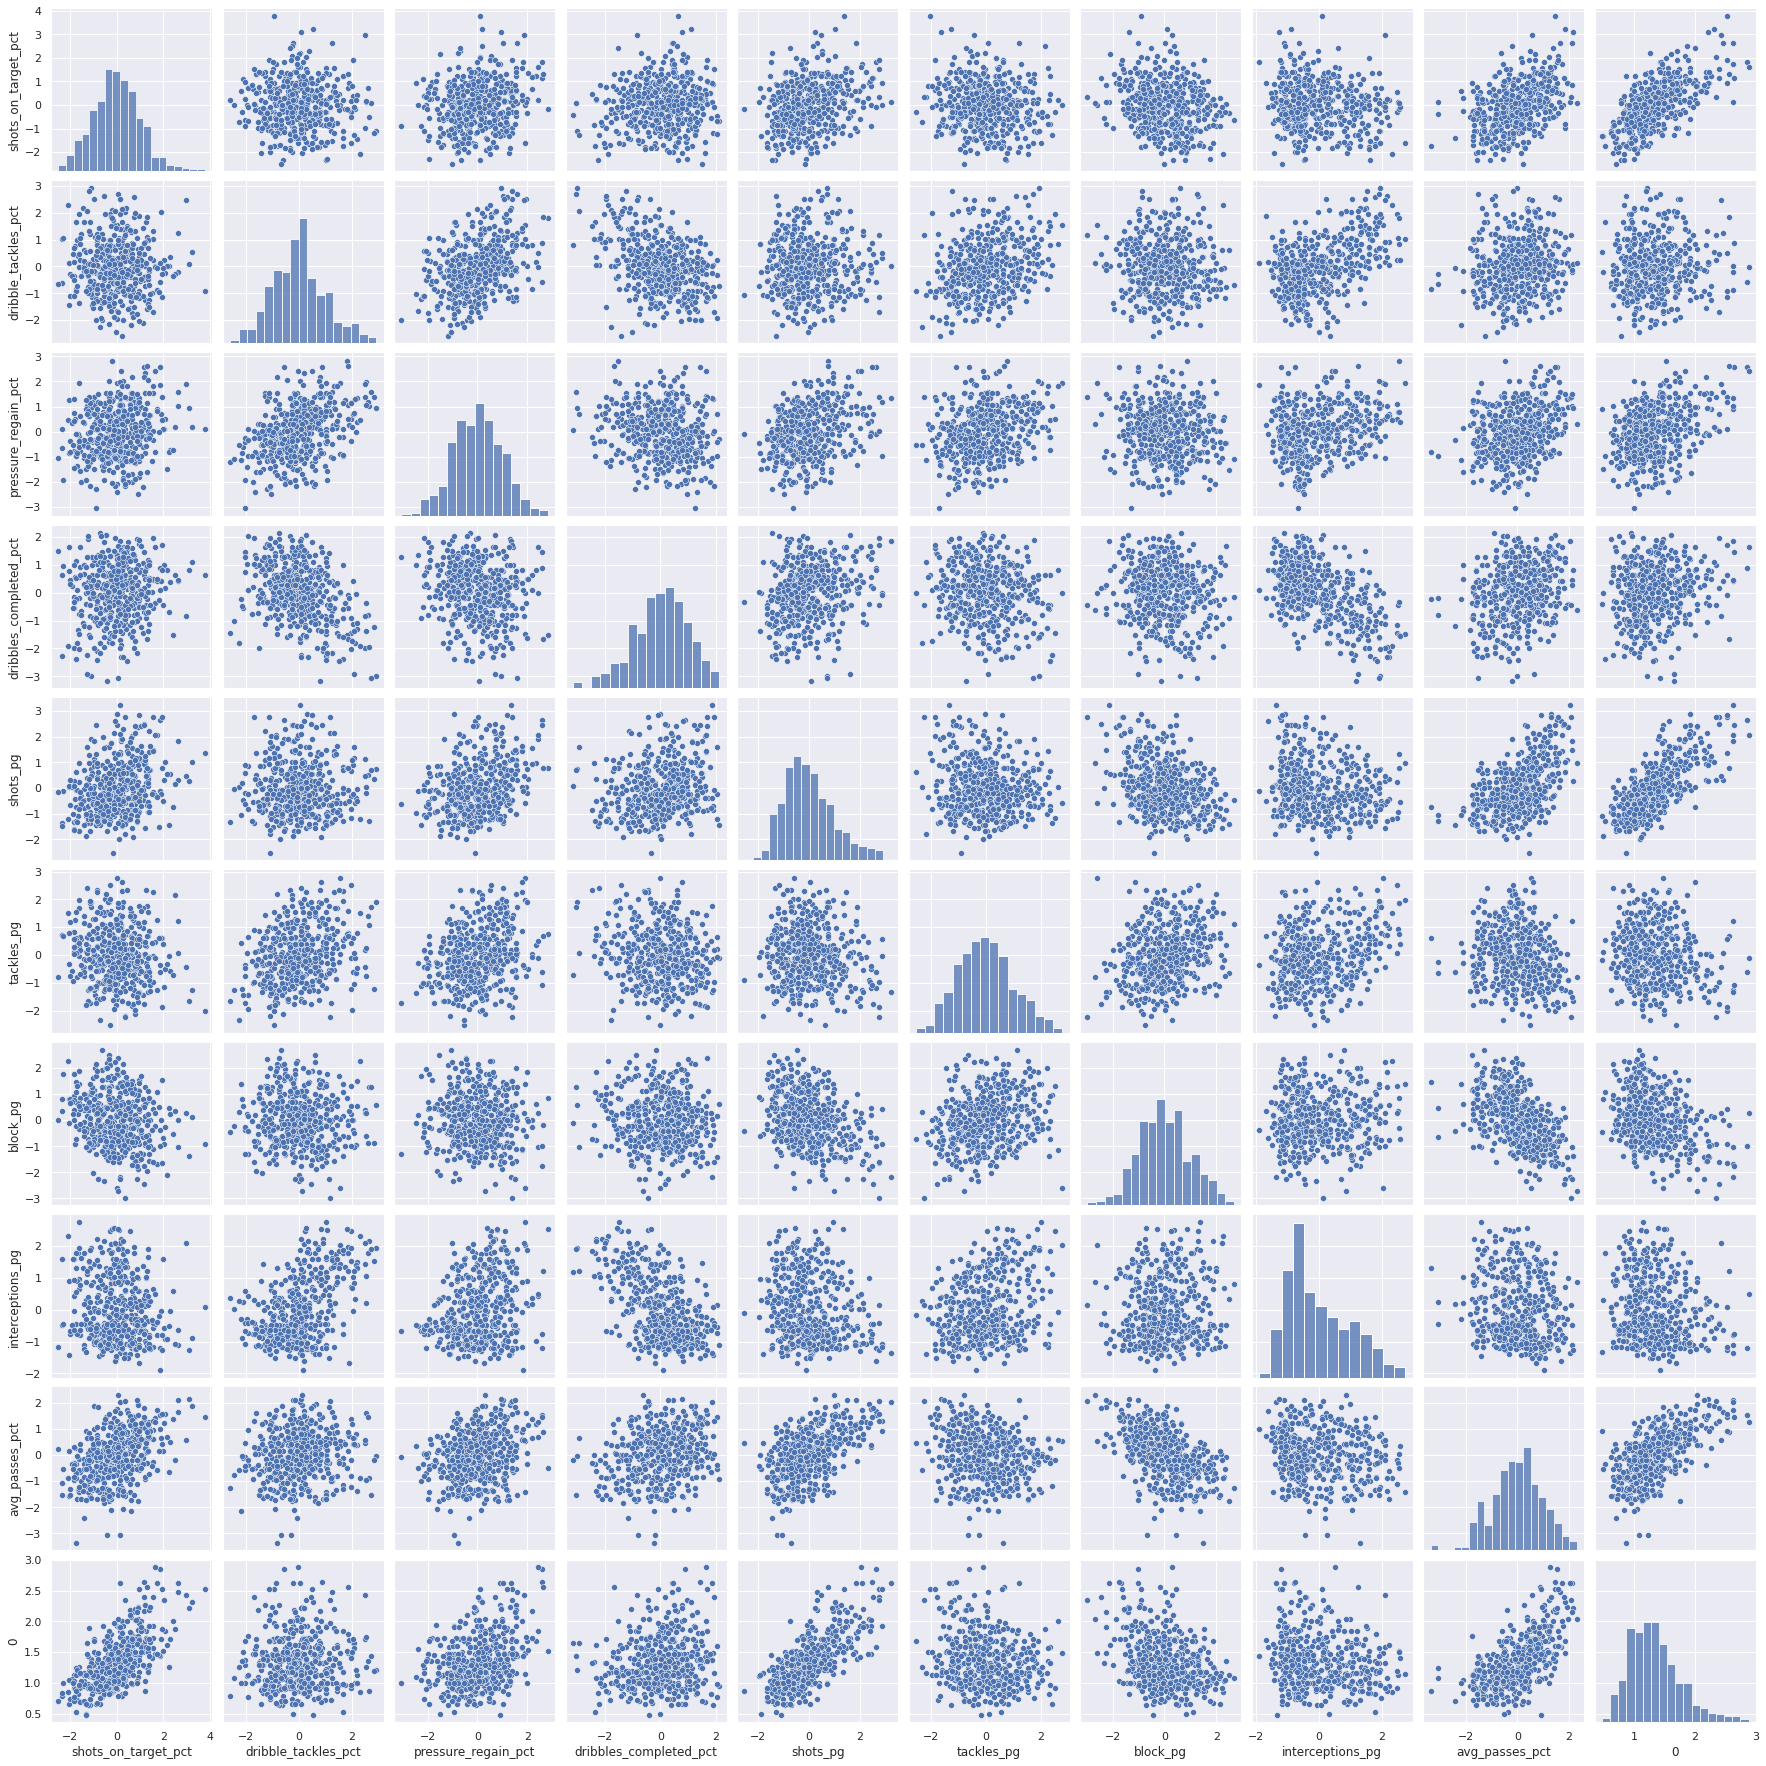

In [128]:
sns.pairplot(pd.concat([X_tr_vif,y_train],axis=1))

In [116]:
#print linear regression information (rmse, mae, p, Durbin_watson statistic, residual plot, QQ plot)
#and return p value of t test for each feature
def lginfo(lm,X,y):
    
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))
    residual = y - predictions
    
    df_stat = pd.DataFrame()
    df_stat['predictions'] = predictions
    df_stat['residual'] = residual.to_numpy()
    
    ############################
    MSE = (sum(residual**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values = [2 * (1 - stats.t.cdf(np.abs(i), (len(newX) - len(newX.columns)))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    var_lst = X_tr_fit.columns.tolist()
    var_lst.insert(0,'const')

    myDF3 = pd.DataFrame()
    myDF3.index = var_lst
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
    print(myDF3)
    
    ############################
    rmse = np.sqrt(sum(residual**2)/len(residual))
    mae = sum(abs(residual))/len(residual)
    print('RMSE:',rmse)
    print('MAE:',mae)
    
    ############################
    #durbin_watson statistic
    print('Durbin_watson statistic:',durbin_watson(residual,axis = 0))

    ############################
    plt.figure()
    with sns.axes_style('white'):
        sns.scatterplot(data=df_stat, x="predictions", y="residual")    
    
    ############################
    plt.figure()
    # diagnose/inspect residual normality using qqplot:
    stats.probplot(residual, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    plt.show()
    
    return myDF3,df_stat
    

In [117]:
def lr_reg_tr_cv(X,y,model,**params):

    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    grid_est = GridSearchCV(model, param_grid=params, cv=kfold, 
                        return_train_score=False)
    grid_est.fit(X, y)
    print('Lambda for regularization:',grid_est.best_estimator_.alpha)
    
#     grid_est.best_estimator_.predict(X)

    reg_info, df_stat = lginfo(grid_est.best_estimator_,X,y)
    
    R2 = grid_est.best_estimator_.score(X, y)
    R2_adjusted = 1 - ( 1 - R2 ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 )
    
    print('R^2 of train data:',R2)
    print('Adjusted R^2 of train data:',R2_adjusted)
    
    return reg_info, grid_est.best_estimator_, grid_est.best_estimator_.alpha

/tmp/ipykernel_2906/380418514.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['avg_passes_pct'] = (X.passes_pct_short + X.passes_pct_medium + X.passes_pct_long)/3


Lambda for regularization: 0.006640827850634838
                        Coefficients  Standard Errors  t values  Probabilities
const                         1.3490            0.009   142.478          0.000
shots_on_target_pct           0.1753            0.011    16.269          0.000
dribble_tackles_pct           0.0000            0.012     0.000          1.000
pressure_regain_pct           0.0348            0.012     2.909          0.004
dribbles_completed_pct       -0.0000            0.012    -0.000          1.000
shots_pg                      0.2054            0.012    16.949          0.000
tackles_pg                   -0.0232            0.011    -2.139          0.033
block_pg                     -0.0000            0.011    -0.000          1.000
interceptions_pg              0.0000            0.013     0.000          1.000
avg_passes_pct                0.0581            0.014     4.022          0.000
RMSE: 0.20351560089630144
MAE: 0.1612138877477166
Durbin_watson statistic: 1.934480

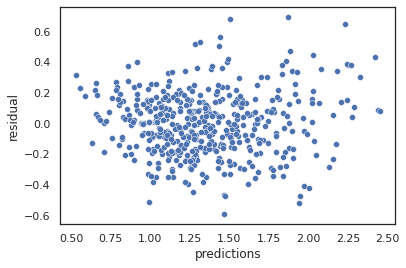

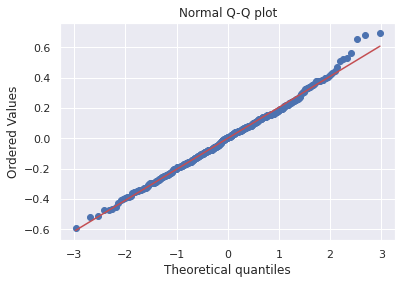

R^2 of train data: 0.7707240419365649
Adjusted R^2 of train data: 0.7662576271690953


In [136]:
# Linear regression analysis to find the significant features contributing to goal won per match in one match season

y = df.goals/df.games
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

## drop features with multicolinearity
X_train = dropvar(X_train)
X_test = dropvar(X_test)


################### Feature engineering ################### 

#Not successful ones
# X_train['dribble_tackles_pct_2'] = 1/X_train.dribble_tackles_pct
# X_train = X_train.drop('dribble_tackles_pct', axis=1).astype(float)

# X_train['dribbles_completed_pct_2'] = 1/X_train.dribbles_completed_pct
# X_train = X_train.drop('dribbles_completed_pct', axis=1).astype(float)

# X_train['interceptions_pg_2'] = X_train.interceptions_pg**0.5
# X_train = X_train.drop('interceptions_pg', axis=1).astype(float)

# X_train['tackles_pg_2'] = 1/X_train.tackles_pg#np.exp(-(X_train.tackles_pg))
# X_train = X_train.drop('tackles_pg', axis=1).astype(float)

# X_train['block_pg_2'] = np.exp(-(X_train.block_pg))
# X_train = X_train.drop('block_pg', axis=1).astype(float)

# X_test['block_pg_2'] = np.exp(-(X_test.block_pg))
# X_test = X_test.drop('block_pg', axis=1).astype(float)

# X_train = X_train.drop(['interceptions_pg','dribble_tackles_pct'], axis=1).astype(float)
# X_test = X_test.drop(['interceptions_pg','dribble_tackles_pct'], axis=1).astype(float)

################### Feature engineering ################### 
std = StandardScaler()
std.fit(X_train.values)

## apply the scaler to the train set
X_tr = pd.DataFrame(std.transform(X_train.values), columns = X_train.columns)
X_tr.index = X_train.index

## Apply the scaler to the test set
X_te = pd.DataFrame(std.transform(X_test.values), columns = X_test.columns)
X_te.index = X_test.index

##################################
X_tr_fit = X_tr
y_tr_fit = y_train

X_te_fit = X_te
y_te_fit = y_test

statDF, lr, opt_reg = lr_reg_tr_cv(X_tr_fit,y_tr_fit,Lasso(),alpha=np.logspace(-4, 0.1, 10))

# feature = []
# feature_old = X_tr_fit.columns.tolist()
# i = 1

# while feature != feature_old:
#     print('---------------------iteration:', i,'---------------------')
#     feature_old = X_tr_fit.columns.tolist()
    
#     statDF, lr, opt_reg = lr_reg_tr_cv(X_tr_fit,y_tr_fit,Lasso(),alpha=np.logspace(-4, 0.1, 10))


#     feature = statDF[statDF.Probabilities<0.6].index.tolist()[1:]
#     X_tr_fit = X_tr_fit[feature]
#     X_te_fit = X_te_fit[feature]
    
#     feature_unsort = feature.copy()
#     feature.sort()
#     feature_old.sort()
#     i += 1

                        Coefficients  Standard Errors  t values  Probabilities
const                         1.3490            0.021    63.036          0.000
shots_on_target_pct           0.1753            0.024     7.180          0.000
dribble_tackles_pct           0.0000            0.028     0.000          1.000
pressure_regain_pct           0.0348            0.026     1.333          0.185
dribbles_completed_pct       -0.0000            0.023    -0.000          1.000
shots_pg                      0.2054            0.026     7.965          0.000
tackles_pg                   -0.0232            0.024    -0.952          0.343
block_pg                     -0.0000            0.024    -0.000          1.000
interceptions_pg              0.0000            0.025     0.000          1.000
avg_passes_pct                0.0581            0.027     2.179          0.031
RMSE: 0.21149217799142364
MAE: 0.16516232273421183
Durbin_watson statistic: 1.7222697664690956


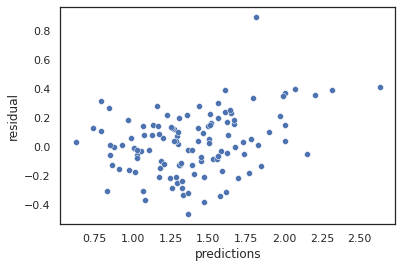

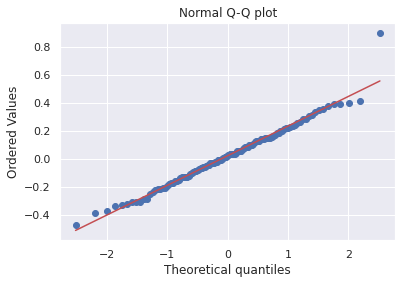

R^2 of test data: 0.7985921310134946
Adjusted R^2 of test data: 0.7929681765566288


In [138]:
# lr_reg_te(X_tr_fit,y_train_fit,X_te_fit,y_te_fit,Lasso(),opt_reg)

lm = Lasso(alpha = opt_reg)

lm.fit(X_tr_fit, y_tr_fit)

pred = lm.predict(X_tr_fit)
resid = y_tr_fit - pred

# print(np.where(resid > 0.8))

# X_te_fit2 = X_te_fit.drop(X_te_fit.index[14])
# y_te_fit2 = y_te_fit.drop(y_te_fit.index[14])

# reg_info, df_stat = lginfo(lm,X_tr_fit,y_tr_fit)
reg_info, df_stat = lginfo(lm,X_te_fit,y_te_fit)

R2 = lm.score(X_te_fit, y_te_fit)
R2_adjusted = 1 - ( 1 - R2 ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 )

print('R^2 of test data:',R2)
print('Adjusted R^2 of test data:',R2_adjusted)

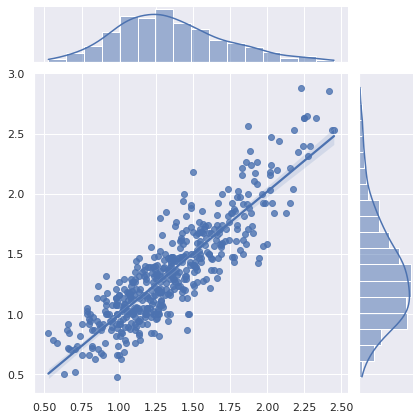

In [139]:
sns.set_style("darkgrid")
sns.jointplot(x = pred, y =y_tr_fit,kind="reg")

<AxesSubplot:>

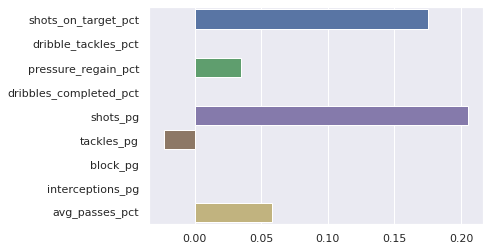

In [140]:
feature = X_tr_fit.columns.tolist()
# feature[-1] = 'exp(-block_pg)'
sns.barplot(x=lm.coef_, y=feature)

In [141]:
X.block_pg

0      13.394737
1      16.368421
2      16.815789
3      17.763158
4      13.421053
         ...    
585    13.852941
586    14.558824
587    12.411765
588    13.235294
589    15.323529
Name: block_pg, Length: 590, dtype: float64